<h1><font color='blue'>INDOOR POSITIONING USE CASE</font></h1>

#### Author:    Riccardo Saruis

<h3><font color='blue'>Scenario and customer request:</font></h3>
<h4><font color='black'>Our customer has a chemical laboratory and in one area of the building there is an high biological risk. 
<br><br>For safety reasons the customer needs to implement a cheap but reliable system to monitoring in real time the employee's movements within the factory. 
<br><br>The target  is to protect employees.
<br><br>1) In case of contamination, at a precise moment they must know which employees were present in which laboratories and their movements so that they can be subjected to health checks if necessary.
<br><br>2) If an employee stays in laboratory 3 for more than 45 minutes, a safety procedure is activated to make sure that the employee is ok.
</font></h4>

<figure>
<img src="laboratory.png" alt="planimetria_1" style="width: 700px;"/>
    <figcaption>Img.1: Laboratory</figcaption>
</figure>

<figure>
<img src="planimetria_1.png" alt="planimetria_1" style="width: 800px;"/>
    <figcaption>Img.2: Building map.</figcaption>
</figure>

<h3><font color='blue'>- Strategy</font></h3>
<h4><font color='black'>To solve this problem we will use AI.</font></h4>

<h4><font color='black'>We will adopt a multiclass classification approach to create a supervised Machine Learning model 
that will learn how to interpret the combinations of RSSI values received from the receivers for recognize the employees's real time position.
    
<br>13 Features = RSSI value receaved from Bluetooth receaver nodes
<br>10 Lables = zones of the building
    
<br>We will choose the best Machine Learning model by competing four supervised ML algorithms:
      
<br> - KNN
<br> - LOGISTIC REGRESSION
<br> - SVM
<br> - RANDOM FOREST</font></h4>

<figure>
<img src="models_competition.png" alt="models tested" style="width: 800px;"/>
    <figcaption>Img.3: ML algorithms to test</figcaption>
</figure>

<h3><font color='blue'>- HW implementation</font></h3>
We will apply a localization solution carried out through the detection of bracelets from Bluetooth Low Energy receivers(BLE 5.0) positioned in various points of the building.

<br>The Bluetooth receaver nodes will detect the power signals(RSSI) transmitted from the Bluetooth bracelets worn by employees.
Every second the receaver nodes will transmit the power signals detected to the server.

<br><br>The goal is to know what zone an employee is in by interpreting the RSSI values.



<figure>
<img src="ip_image.png" alt="ip_image" style="width: 400px;"/>
<figcaption>Img.4: Indoor Positioning</figcaption>
</figure>

<figure>
<img src="planimetria_2.png" alt="planimetria_1" style="width: 800px;"/>
    <figcaption>Img.5: Indoor Positioning HW elements map.</figcaption>
</figure>

<h3><font color='blue'>- Data collection method and unit of measure</font></h3>
<br><h4><font color='black'>A fundamental part of our work concerns of course the quality of the incoming data and therefore how they are collected.</font></h4>
<br><br>To have more reliable data, the final dataset consists of 4 folds(live data), everyone with RSSI measures obtained at different times, on different days, with different devices in operation (which will interfere differently with the Bluetooth signal) and with a different number of employees in the building.
<br><br>Each fold (fold0-fold1-fold2-fold3) contains the measurements obtained with a single bracelet worn by an employee who, for 30-45 minutes, moves in all zones. An employee set the label of a zone and moving in the whole space, then set the label of the next zone and moving in the whole space and so on.. In this way it produces folds with features and lables to train the ML supervised algorithms.


<br><br>But, before to start with code..  what is the RSSI?
<h4><font color='black'>The "Received Signal Strength Indicator"(RSSI)is a measure of the power level at the receiver, is measured in dBm (or dBmW = decibel milliwatt) on a logarithmic and negative scale. 
<br>1dBm = 1 milliwatt.</font></h4>


<figure>
<img src="dBm_mW.png" alt="RSSI" style="width: 500px;"/>
    <figcaption>Img.6: dBm scale</figcaption>
</figure>

<figure>
<img src="6_level_rssi.png" alt="RSSI" style="width: 300px;"/>
    <figcaption>Img.7: 6-Level FM RSSI scale</figcaption>
</figure>

<h3><font color='blue'>- Python libraries import</font></h3>

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import itertools

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, LeaveOneGroupOut
from numpy import mean, std

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import sys
sys.path.append('..')
from IP_lib.plot_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
class bcolors:
    PERSONAL = '\033[94m'+'\033[1m'
    ENDC = '\033[0m'


<h3><font color='blue'>1 - Importing data (Time Series)</font></h3>
<br>Importing 1 of 4 data folds

In [6]:
f0 = pd.read_csv('../IP_data/ipdata_fold0.csv', parse_dates=True,index_col='time')
f0.head()

,node_id,rssi,zone
time,,,
2020-04-17 18:59:14.998178722+00:00,B04,-82,L2
2020-04-17 18:59:14.998881474+00:00,B04,-90,L2
2020-04-17 18:59:15.778636414+00:00,B03,-85,L2
2020-04-17 18:59:15.779954940+00:00,B06,-86,L2
2020-04-17 18:59:16.014617868+00:00,D03,-83,L2


In [7]:
# zone list

sorted(f0.zone.unique())

['AB1', 'AB2', 'B1', 'B2', 'F', 'L1', 'L2', 'M', 'S1', 'S2']

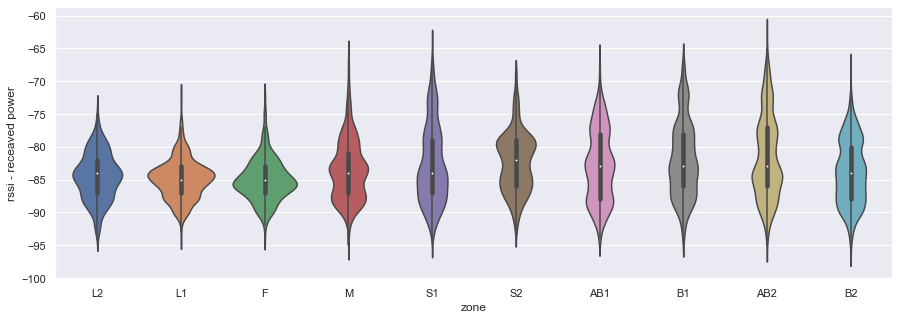

In [8]:
# RSSI distribution by zones

plt.figure(figsize=(15,5))
sns.violinplot(data=f0,
    x='zone',
    y='rssi')

plt.xlabel('zone')
plt.ylabel('rssi - receaved power');

<h3><font color='blue'>2 - Data manipulation</font></h3>
Since they are all numerical continuous features with the same unit of measure and order of magnitude, scaling and one hot are not necessary

<h4><font color='blue'>Fold0 manipulation</font></h4>

In [9]:
# raw data Fold0

f0.head()

,node_id,rssi,zone
time,,,
2020-04-17 18:59:14.998178722+00:00,B04,-82,L2
2020-04-17 18:59:14.998881474+00:00,B04,-90,L2
2020-04-17 18:59:15.778636414+00:00,B03,-85,L2
2020-04-17 18:59:15.779954940+00:00,B06,-86,L2
2020-04-17 18:59:16.014617868+00:00,D03,-83,L2


In [10]:
# Creation of a column for each feature using the pivot table

fold0 = f0.pivot(columns='node_id', values='rssi')
fold0.head()

node_id,B01,B02,B03,B04,B05,B06,C01,C02,C03,D01,D02,D03,D04
time,,,,,,,,,,,,,
2020-04-17 18:59:14.998178722+00:00,NaN,NaN,NaN,-82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-17 18:59:14.998881474+00:00,NaN,NaN,NaN,-90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-17 18:59:15.778636414+00:00,NaN,NaN,-85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-17 18:59:15.779954940+00:00,NaN,NaN,NaN,NaN,NaN,-86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-17 18:59:16.014617868+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-83.0,NaN


In [11]:
# Lables

f0.zone.head()

time
2020-04-17 18:59:14.998178722+00:00    L2
2020-04-17 18:59:14.998881474+00:00    L2
2020-04-17 18:59:15.778636414+00:00    L2
2020-04-17 18:59:15.779954940+00:00    L2
2020-04-17 18:59:16.014617868+00:00    L2
Name: zone, dtype: object

<h4><font color='blue'>Rolling, Resample and fillna</font></h4>
We need to extract more homogeneous but not too similar values
<br>We need to replace the no signal values with -100 dBm (RSSI)

In [12]:
# Rolling, Resample and fillna
 
fold0 = fold0.rolling('3s').mean().round(0)
fold0 = fold0.resample('1s').last()
fold0['y'] = f0.zone.resample('1s').last()
fold0.dropna(axis=0, how='all', inplace=True)
fold0 = fold0.fillna(-100)                   #<---   0 signal = -100 dBm
fold0['fold'] = pd.Series()                  #<---  we need to insert a temporary series with the number of the fold
fold0['fold'] = np.repeat(0, fold0.shape[0]) #      to use this folds for the CV by the LeaveOneGroupOut 
fold0.head()


node_id,B01,B02,B03,B04,B05,B06,C01,C02,C03,D01,D02,D03,D04,y,fold
time,,,,,,,,,,,,,,,
2020-04-17 18:59:14+00:00,-100.0,-100.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,L2,0
2020-04-17 18:59:15+00:00,-100.0,-100.0,-85.0,-86.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,L2,0
2020-04-17 18:59:16+00:00,-100.0,-100.0,-84.0,-85.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-83.0,-100.0,L2,0
2020-04-17 18:59:18+00:00,-89.0,-100.0,-84.0,-83.0,-100.0,-87.0,-85.0,-100.0,-100.0,-100.0,-100.0,-85.0,-100.0,L2,0
2020-04-17 18:59:19+00:00,-88.0,-100.0,-84.0,-83.0,-100.0,-87.0,-84.0,-100.0,-100.0,-100.0,-100.0,-86.0,-100.0,L2,0


In [13]:
# Statistical measures on features

fold0.describe().T

,count,mean,std,min,25%,50%,75%,max
node_id,,,,,,,,
B01,3212.0,-97.761208,5.363807,-100.0,-100.0,-100.0,-100.0,-76.0
B02,3212.0,-97.230697,5.681576,-100.0,-100.0,-100.0,-100.0,-75.0
B03,3212.0,-94.961706,7.500157,-100.0,-100.0,-100.0,-86.0,-75.0
B04,3212.0,-96.971357,5.979550,-100.0,-100.0,-100.0,-100.0,-78.0
B05,3212.0,-98.218244,4.913009,-100.0,-100.0,-100.0,-100.0,-72.0
B06,3212.0,-97.496264,5.673757,-100.0,-100.0,-100.0,-100.0,-78.0
C01,3212.0,-93.837484,7.830284,-100.0,-100.0,-100.0,-86.0,-68.0
C02,3212.0,-95.315068,7.905293,-100.0,-100.0,-100.0,-88.0,-69.0
C03,3212.0,-93.535181,7.325825,-100.0,-100.0,-100.0,-88.0,-72.0


<h4><font color='blue'>Fold 1-2-3 data inport and manipulation</font></h4>

In [14]:
fold1, fold2, fold3 = [],[],[] 
ipdata = ['ipdata_fold1', 'ipdata_fold2', 'ipdata_fold3']
folds = ['fold1', 'fold2', 'fold3']

for i, f in enumerate(folds):
    fraw = pd.read_csv(f'../IP_data/{ipdata[i]}.csv', parse_dates=True,index_col='time')
    f = fraw.pivot(columns='node_id', values='rssi')
    f = f.rolling('3s').mean().round(0)
    f = f.resample('1s').last()
    f['y'] = fraw.zone.resample('1s').last()
    f.dropna(axis=0, how='all', inplace=True)
    f = f.fillna(-100)                      #<---   0 signal = -100 dBm
    f['fold'] = pd.Series()                 #<---  we need to insert a temporary series with the number of the fold
    f['fold'] = np.repeat(i+1, f.shape[0])  #      to use this folds for the CV by the LeaveOneGroupOut 
    if i==0:
        fold1=f
    elif i==1:
        fold2=f
    elif i==2:
        fold3=f
    
fold0.shape, fold1.shape, fold2.shape, fold3.shape

((3212, 15), (3067, 15), (3942, 15), (2727, 15))

In [15]:
fold1.head(2)

node_id,B01,B02,B03,B04,B05,B06,C01,C02,C03,D01,D02,D03,D04,y,fold
time,,,,,,,,,,,,,,,
2020-04-20 12:55:02+00:00,-100.0,-100.0,-100.0,-100.0,-84.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,F,1
2020-04-20 12:55:03+00:00,-100.0,-100.0,-100.0,-100.0,-86.0,-82.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,F,1


In [16]:
fold2.head(2)

node_id,B01,B02,B03,B04,B05,B06,C01,C02,C03,D01,D02,D03,D04,y,fold
time,,,,,,,,,,,,,,,
2020-04-22 12:05:00+00:00,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-86.0,-72.0,-77.0,-100.0,-100.0,-100.0,-89.0,S1,2
2020-04-22 12:05:01+00:00,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-86.0,-71.0,-76.0,-100.0,-100.0,-100.0,-89.0,S1,2


In [17]:
fold3.head(2)

node_id,B01,B02,B03,B04,B05,B06,C01,C02,C03,D01,D02,D03,D04,y,fold
time,,,,,,,,,,,,,,,
2020-04-22 15:17:59+00:00,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-78.0,-85.0,-100.0,-100.0,-100.0,-100.0,S1,3
2020-04-22 15:18:00+00:00,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-86.0,-76.0,-83.0,-100.0,-100.0,-100.0,-100.0,S1,3


In [18]:
# now we concatenate the 4 data folds

data = [fold0, fold1, fold2, fold3]
data = pd.concat(data)
data.shape

(12948, 15)

In [19]:
data.head()

node_id,B01,B02,B03,B04,B05,B06,C01,C02,C03,D01,D02,D03,D04,y,fold
time,,,,,,,,,,,,,,,
2020-04-17 18:59:14+00:00,-100.0,-100.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,L2,0
2020-04-17 18:59:15+00:00,-100.0,-100.0,-85.0,-86.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,L2,0
2020-04-17 18:59:16+00:00,-100.0,-100.0,-84.0,-85.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-83.0,-100.0,L2,0
2020-04-17 18:59:18+00:00,-89.0,-100.0,-84.0,-83.0,-100.0,-87.0,-85.0,-100.0,-100.0,-100.0,-100.0,-85.0,-100.0,L2,0
2020-04-17 18:59:19+00:00,-88.0,-100.0,-84.0,-83.0,-100.0,-87.0,-84.0,-100.0,-100.0,-100.0,-100.0,-86.0,-100.0,L2,0


In [20]:
# Dataset dump

data.to_csv('../IP_data/ipdata_allfold.csv')
pickle.dump(data, open('../IP_data/ipdata_allfold.pkl', 'wb'))

<h4><font color='blue'>3 - Features, Lables and Folds indicator</font></h4>

In [21]:
# Now we separate the series with the number of the fold and data indexes
# to use this indexes, linked to the original folds, in the CV by the LeaveOneGroupOut

fold_num = data.pop('fold')
fold_num

time
2020-04-17 18:59:14+00:00    0
2020-04-17 18:59:15+00:00    0
2020-04-17 18:59:16+00:00    0
2020-04-17 18:59:18+00:00    0
2020-04-17 18:59:19+00:00    0
                            ..
2020-04-22 16:13:30+00:00    3
2020-04-22 16:13:31+00:00    3
2020-04-22 16:13:32+00:00    3
2020-04-22 16:13:33+00:00    3
2020-04-22 16:13:34+00:00    3
Name: fold, Length: 12948, dtype: int32

In [22]:
y = data.pop('y')
y.head()

time
2020-04-17 18:59:14+00:00    L2
2020-04-17 18:59:15+00:00    L2
2020-04-17 18:59:16+00:00    L2
2020-04-17 18:59:18+00:00    L2
2020-04-17 18:59:19+00:00    L2
Name: y, dtype: object

In [23]:
X = data
X.head()

node_id,B01,B02,B03,B04,B05,B06,C01,C02,C03,D01,D02,D03,D04
time,,,,,,,,,,,,,
2020-04-17 18:59:14+00:00,-100.0,-100.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2020-04-17 18:59:15+00:00,-100.0,-100.0,-85.0,-86.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2020-04-17 18:59:16+00:00,-100.0,-100.0,-84.0,-85.0,-100.0,-86.0,-100.0,-100.0,-100.0,-100.0,-100.0,-83.0,-100.0
2020-04-17 18:59:18+00:00,-89.0,-100.0,-84.0,-83.0,-100.0,-87.0,-85.0,-100.0,-100.0,-100.0,-100.0,-85.0,-100.0
2020-04-17 18:59:19+00:00,-88.0,-100.0,-84.0,-83.0,-100.0,-87.0,-84.0,-100.0,-100.0,-100.0,-100.0,-86.0,-100.0


In [24]:
X.shape, y.shape

((12948, 13), (12948,))

In [25]:
# Recap

n_id = X.columns
z_id = y.unique()

print(f"{bcolors.PERSONAL}\nThe fold's number are:\n{fold_num.unique()}{bcolors.ENDC}")
print(f'{bcolors.PERSONAL}\n\nX --> The number of nodes is: {n_id.shape[0]}{bcolors.ENDC}')
print(f'{bcolors.PERSONAL}\n\ny --> The number of zones is: {z_id.shape[0]}{bcolors.ENDC}')
print(f'{bcolors.PERSONAL}\nThe node IDs are:\n{sorted(n_id)}{bcolors.ENDC}')
print(f'{bcolors.PERSONAL}\n\nThe zones IDs are:\n{sorted(z_id)}{bcolors.ENDC}')
print(f'{bcolors.PERSONAL}\n\nThe samples for each zone are:\n{y.value_counts()}{bcolors.ENDC}')


The fold's number are:
[0 1 2 3]


X --> The number of nodes is: 13


y --> The number of zones is: 10

The node IDs are:
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'C01', 'C02', 'C03', 'D01', 'D02', 'D03', 'D04']


The zones IDs are:
['AB1', 'AB2', 'B1', 'B2', 'F', 'L1', 'L2', 'M', 'S1', 'S2']


The samples for each zone are:
L2     1876
S1     1733
S2     1653
L1     1584
F      1322
AB1    1164
M      1021
B2      968
AB2     825
B1      802
Name: y, dtype: int64


<h3><font color='blue'> 4 - EDA (Exploratory Data Analysis)</font></h3>

<h4><font color='blue'>At a graphic level we try to understand how 4 folds power signals(RSSI) changes during the observations, this will helps us to have useful insights</font></h4>
<br>In this case it shows show the RSSI measures detected by Bluetooth receavers for a single employee during the collection of 4 folds (each bracelet / employee has an ID which has not been taken into consideration at this stage)

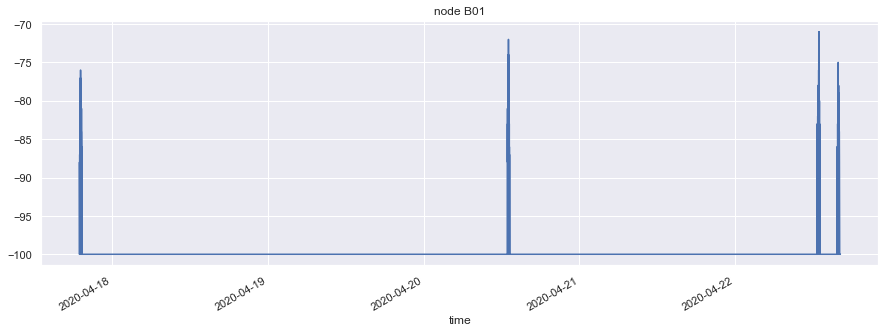

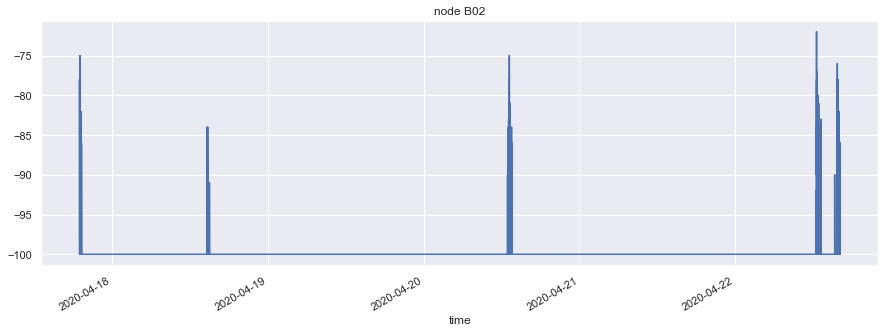

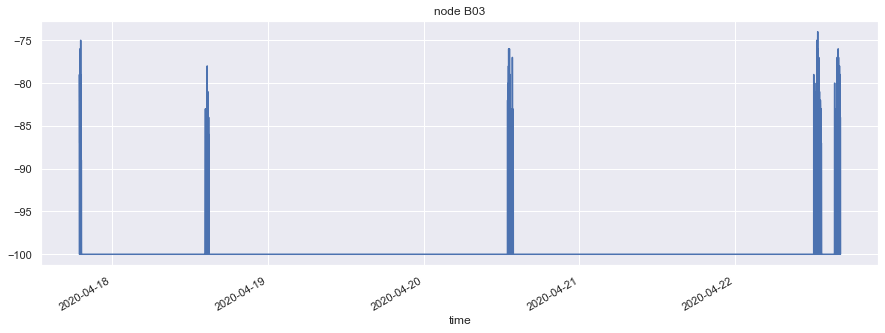

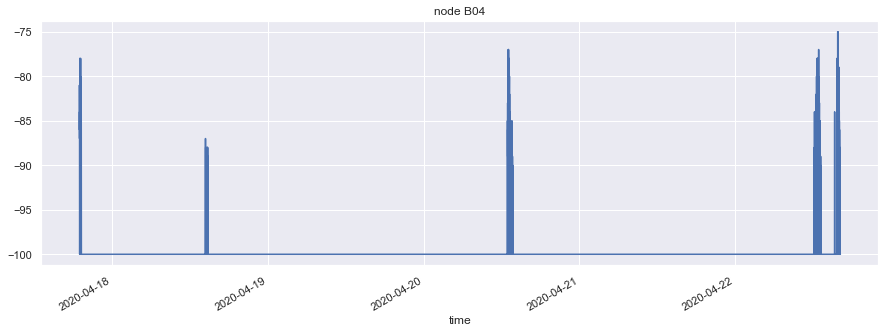

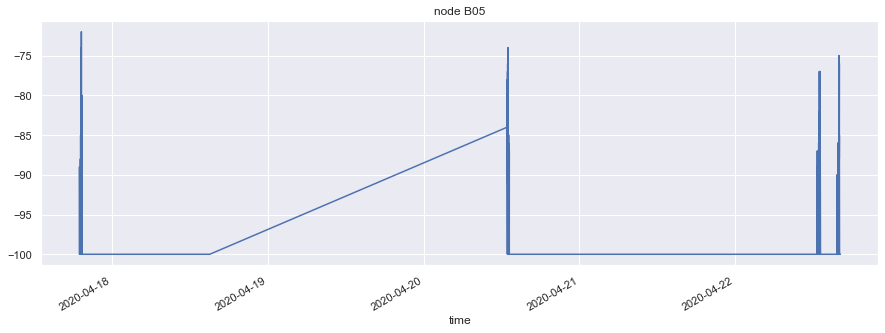

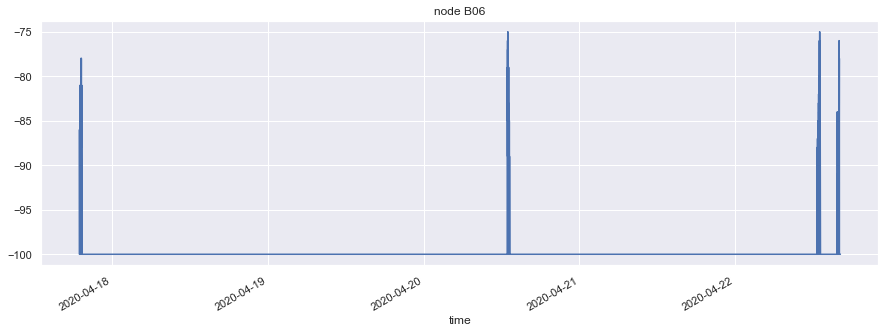

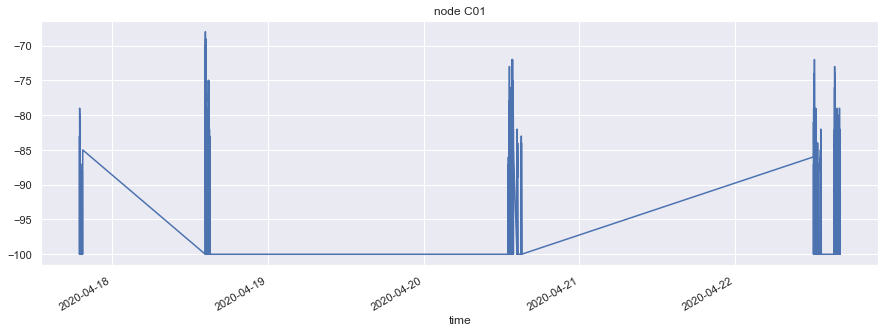

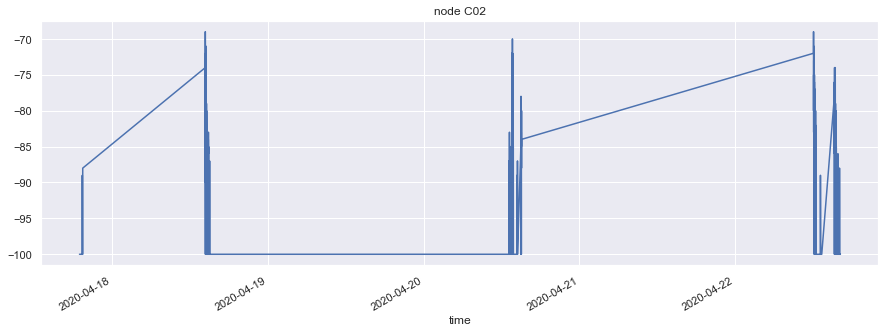

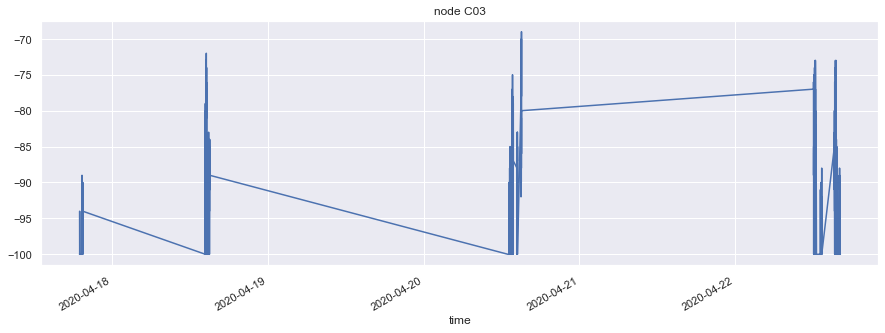

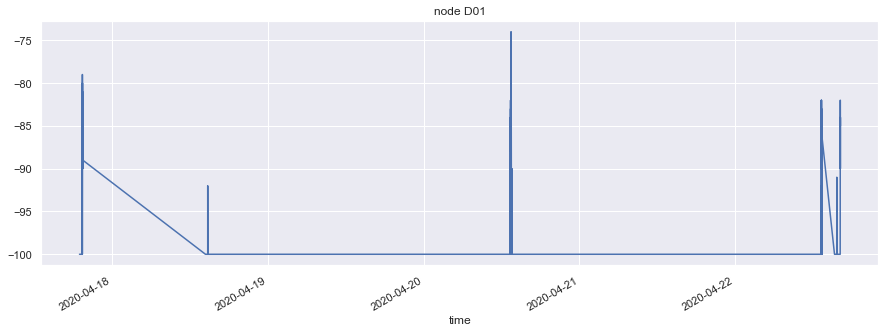

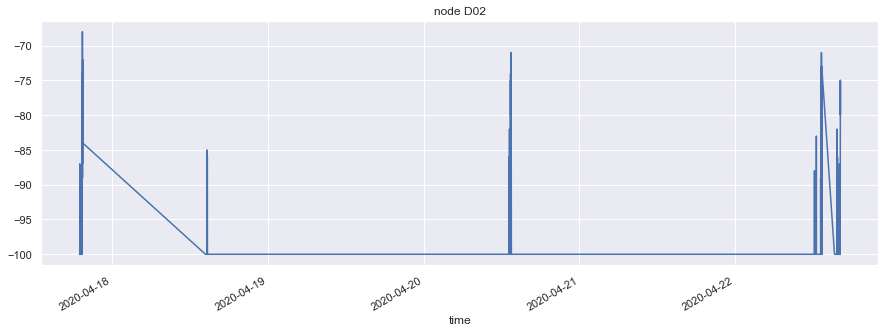

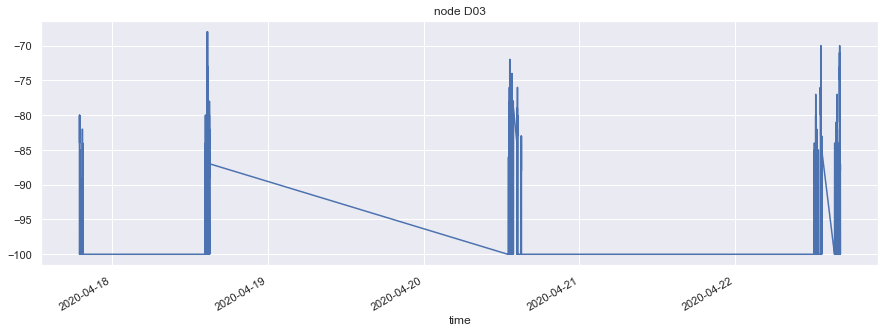

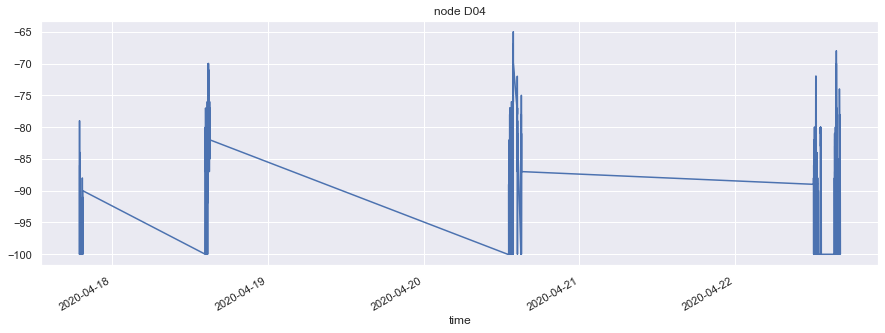

In [26]:
# let's see at what times, days and with what powers the nodes receive

for n in n_id:
    plt.figure(figsize=(15,5))
    data[n].plot(title = f'node {n}');

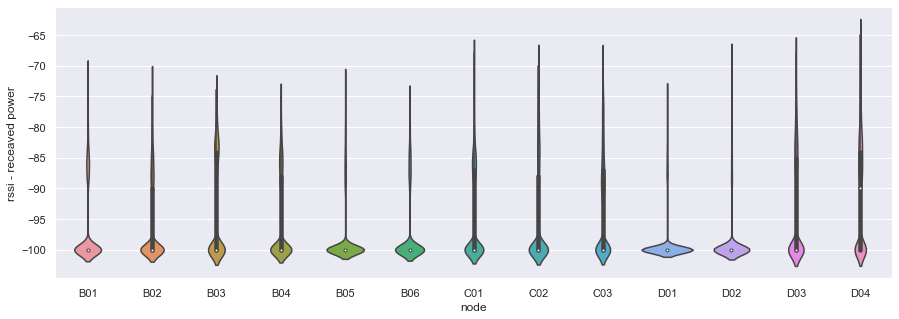

In [27]:
# RSSI distribution by receaver nodes

plt.figure(figsize=(15,5))
sns.violinplot(data=X)

plt.xlabel('node')
plt.ylabel('rssi - receaved power');

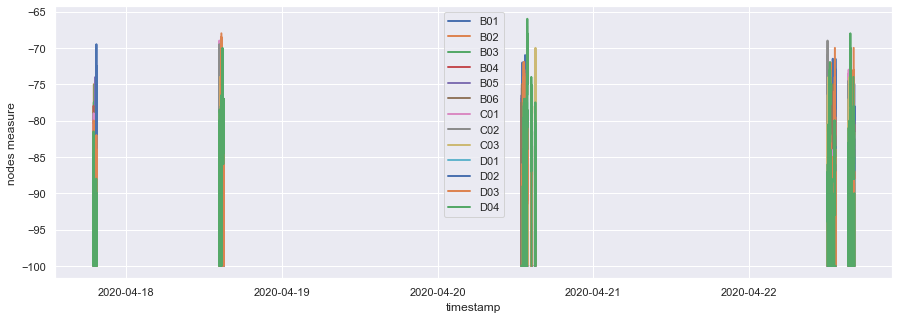

In [28]:
# Analysis of signals received in the time interval

plt.figure(figsize=(15,5))

for n in n_id:
    plt.plot(data[n].resample('2s').mean(), linewidth=2, label=n)

plt.xlabel('timestamp')
plt.ylabel('nodes measure')
plt.legend();

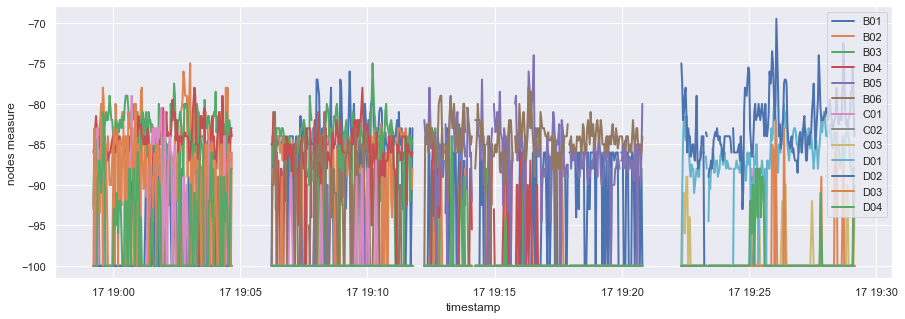

In [29]:
# zoom on a time interval

plt.figure(figsize=(15,5))

for n in n_id:
    plt.plot(data[n]['2020-04-17 17:00':'2020-04-17 20:00'].resample('2s').mean(), linewidth=2, label=n)

plt.xlabel('timestamp')
plt.ylabel('nodes measure')
plt.legend();

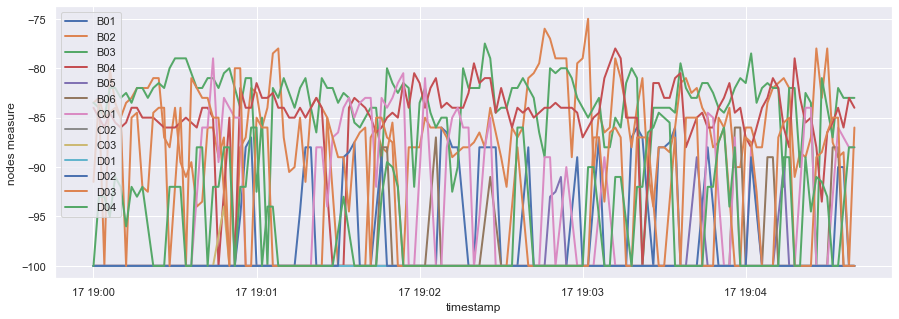

In [30]:
# zoom on a time interval

plt.figure(figsize=(15,5))

for n in n_id:
    plt.plot(data[n]['2020-04-17 19:00':'2020-04-17 19:05'].resample('2s').mean(), linewidth=2, label=n)

plt.xlabel('timestamp')
plt.ylabel('nodes measure')
plt.legend();

<h4><font color='blue'>interactive analysis</font></h4>

In [31]:
# It allows us to filter based on the power received by a receiver in a time interval

def i(node, t1, t2):
    plt.figure(figsize=(15,5))
    plt.plot(data[node][t1:t2].resample('2s').mean(), linewidth=2, label=n)

    plt.xlabel('timestamp')
    plt.ylabel('nodes measure')
    plt.legend();

interact(i, node=n_id, t1='2020-04-17 18:30', t2='2020-04-17 19:30');

interactive(children=(Dropdown(description='node', options=('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'C01', '…

<h3><font color='blue'>5 - Nested cross validation</font></h3>
Nested cross-validation is an approach to model hyperparameter optimization and model selection that attempts to overcome the problem of overfitting the training dataset. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search.
<br><br>In essence we are interested to find the model that performs best on this data, therefore the best algorithm with the best hyperparameters.

In [32]:
# For future debug I prefer to not reset indices

"""
fold0.reset_index(drop=True, inplace=True)
fold0.head(2)
""";

<h4><font color='blue'>Manipolation pre LeaveOneGroupOut to use a 4Fold with our folds</font></h4>

In [33]:
# By folds indexes mask we will separate train and test sets

train_mask = fold_num.isin([0,1,2])
train_mask

time
2020-04-17 18:59:14+00:00     True
2020-04-17 18:59:15+00:00     True
2020-04-17 18:59:16+00:00     True
2020-04-17 18:59:18+00:00     True
2020-04-17 18:59:19+00:00     True
                             ...  
2020-04-22 16:13:30+00:00    False
2020-04-22 16:13:31+00:00    False
2020-04-22 16:13:32+00:00    False
2020-04-22 16:13:33+00:00    False
2020-04-22 16:13:34+00:00    False
Name: fold, Length: 12948, dtype: bool

In [34]:
test_mask = fold_num.isin([3])
test_mask

time
2020-04-17 18:59:14+00:00    False
2020-04-17 18:59:15+00:00    False
2020-04-17 18:59:16+00:00    False
2020-04-17 18:59:18+00:00    False
2020-04-17 18:59:19+00:00    False
                             ...  
2020-04-22 16:13:30+00:00     True
2020-04-22 16:13:31+00:00     True
2020-04-22 16:13:32+00:00     True
2020-04-22 16:13:33+00:00     True
2020-04-22 16:13:34+00:00     True
Name: fold, Length: 12948, dtype: bool

In [35]:
X_train, y_train = X[train_mask], y[train_mask]
folds_train = fold_num[train_mask]

X_train.shape, y_train.shape

((10221, 13), (10221,))

In [36]:
X_test, y_test = X[test_mask], y[test_mask]
folds_test = fold_num[test_mask]

X_test.shape, y_test.shape

((2727, 13), (2727,))

<h4><font color='blue'>Metric</font></h4>

In [37]:
scoring = make_scorer(balanced_accuracy_score)

<h4><font color='blue'>Algorithms and hyperparameters to test</font></h4>

In [38]:
# To not require a too high computational capacity and reduce process time, 
# at this moment we prefer to not have too many hyperparameters to test

estimators = [(KNeighborsClassifier(), {'n_neighbors': list(np.arange((X.shape[0]*1)/100, 
                                                                      (X.shape[0]*2)/100,
                                                                      (X.shape[0]*5)/100, dtype=int))}),\
              
              (LogisticRegression(), {'C':[1e-3, 1e-2, 1e-1, 1]}),\
              
              (SVC(kernel='linear'), {'C':[1e-3, 1e-2, 1e-1, 1]}),\
              (SVC(kernel='rbf'), {'C':[1e-3, 1e-2, 1e-1, 1],'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]}),\
              
              (RandomForestClassifier(class_weight='balanced',n_jobs=-1, random_state=7),
                                           {'max_features':[1,2,3,4,5]})]


<h4><font color='blue'>Cross validation and selection of the best model for this dataset</font></h4>

In [39]:

all_models_best_score = 0
all_models_best_model = []
all_models_best_test_preds = []

print(f'Tested models - nested cross vallidation results:\n')

logo = LeaveOneGroupOut()
inner_group = fold_num.isin([0,1,2])
outer_group = fold_num

inner_logo = logo.get_n_splits(groups=inner_group)
outer_logo = logo.get_n_splits(groups=outer_group)
                                
    
for model, params in estimators:
    
    gs_procedure = GridSearchCV(model, param_grid=params, cv=inner_logo, scoring=scoring, n_jobs=-1)
    gs_procedure.fit(X_train, y_train, groups=folds_train)
    
    test_preds = gs_procedure.predict(X_test)
    
    single_model_best_score = gs_procedure.best_score_
    single_model_best_params = gs_procedure.best_params_

    single_model_cv_score_mean = cross_val_score(gs_procedure, X=X, y=y, 
                                                 cv=outer_logo, scoring=scoring, n_jobs=-1).mean()
    
    
    print(f'\nModel: {bcolors.PERSONAL}{model}{single_model_best_params}{bcolors.ENDC}')
    print(f'Cross_val_score mean: {bcolors.PERSONAL}{single_model_cv_score_mean.round(4)}{bcolors.ENDC}\n')

    
    if single_model_cv_score_mean>all_models_best_score:
        all_models_best_model = [model]+[single_model_best_params]
        all_models_best_score = single_model_cv_score_mean
        all_models_best_test_preds = test_preds
        

Tested models - nested cross vallidation results:


Model: KNeighborsClassifier(){'n_neighbors': 129}
Cross_val_score mean: 0.8222


Model: LogisticRegression(){'C': 0.1}
Cross_val_score mean: 0.8366


Model: SVC(kernel='linear'){'C': 0.1}
Cross_val_score mean: 0.8414


Model: SVC(){'C': 1, 'gamma': 0.001}
Cross_val_score mean: 0.8503


Model: RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=7){'max_features': 2}
Cross_val_score mean: 0.8346



In [57]:
print(f"The best model for this dataset is: \n{bcolors.PERSONAL}{all_models_best_model}(kernel='rbf'){bcolors.ENDC},\
      \n\nWith score: \n{bcolors.PERSONAL}{all_models_best_score:.4f}{bcolors.ENDC}")

The best model for this dataset is: 
[SVC(), {'C': 1, 'gamma': 0.001}](kernel='rbf'),      

With score: 
0.8503


In [48]:
print(f'{bcolors.PERSONAL}\nConfusion Matrix:\n{confusion_matrix(y_test,all_models_best_test_preds)}{bcolors.ENDC}')
print(f'{bcolors.PERSONAL}\n\nClassification report:\n{classification_report(y_test,all_models_best_test_preds)}{bcolors.ENDC}')


Confusion Matrix:
[[235   1  48   4   0   0   0   0   0   0]
 [  0  83   0   1   0   0   0   0   1   1]
 [  5   0  92   5   0   0   0   0   0   0]
 [  0   5   1 164   0   0   0   0   0   0]
 [  0   0   0   0 186  25   0   0   0   0]
 [  0   0   0   0  15 314  30   0   0   0]
 [ 25   0  18   0   0  95 387   0   2   0]
 [  0   0   0   0   0   0   0  71   0   0]
 [  0   1   0   2   0   0   0   0 423  84]
 [  0  19   0  10   0   0   0   0   6 368]]


Classification report:
              precision    recall  f1-score   support

         AB1       0.89      0.82      0.85       288
         AB2       0.76      0.97      0.85        86
          B1       0.58      0.90      0.70       102
          B2       0.88      0.96      0.92       170
           F       0.93      0.88      0.90       211
          L1       0.72      0.87      0.79       359
          L2       0.93      0.73      0.82       527
           M       1.00      1.00      1.00        71
          S1       0.98      0.83     

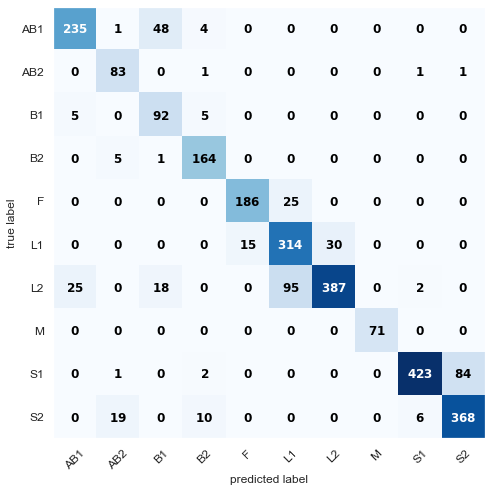

In [49]:
plot_confusion_matrix(y_test,
                      all_models_best_test_preds,
                      class_names=sorted(np.unique(y)),              
                      figsize=(7,7),                      
                      min_disp_perc=0.05,
                      nfloats=2,
                      nhits=True,
                      percentages=False)

<h3><font color='blue'>6 - Conclusions</font></h3>

<h2><font color='green'>The winner is...   SVM!!</font></h2>
For now..I will improve the code with other techniques to obtain higher performances and have lower cost of ownership during model lifecycle.

In [56]:
print(f"The best model for this dataset is: \n{bcolors.PERSONAL}{all_models_best_model}(kernel='rbf'){bcolors.ENDC},\
      \n\nWith score: \n{bcolors.PERSONAL}{all_models_best_score:.4f}{bcolors.ENDC}")

The best model for this dataset is: 
[SVC(), {'C': 1, 'gamma': 0.001}](kernel='rbf'),      

With score: 
0.8503


<figure>
<img src="models_competition_win.png" alt="models tested" style="width: 800px;"/>
    <figcaption>Img.8: ML Models tested</figcaption>
</figure>

<h4><font color='black'>
Putting four Machine Learng models in competition for this multiclass classification case, the one that had the best performances is SVM.<br><br>
Now that we have obtained the winner algorithm trained (model), the Bluetooth receivers will send in real time the measurements to the server and every second this data will be: imported, manipulated and supplied to the model to have the predictions of the areas in which the employees are located.</font></h4>

<figure>
<img src="planimetria_2.png" alt="planimetria_1" style="width: 700px;"/>
    <figcaption>Img.9: Indoor Positioning HW elements map.</figcaption>
</figure>

<figure>
<img src="final_cycle.png" alt="models tested" style="width: 800px;"/>
    <figcaption>Img.10: Indoor Positioning system final cycle</figcaption>
</figure>